In [1]:
# libraries
import pandas as pd   
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#ignore warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
# stop fuzzy charts
%config InlineBackend.figure_format = "retina"

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity ='all'

In [5]:
# for visualising the trees
!pip install pydotplus

In [6]:
!pip install six

In [7]:
# install latest version of scikit for the decision tree and random forest visualisations
!pip install --upgrade scikit-learn==1.0.2

### Data preparation
preparing X and y. Encoding categories for day, month and bank holiday. Using feature scaling because of the wide numeric values for in, out and value

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
dataset = pd.read_csv('data/streets.csv')
dataset

Date       IN      OUT        street    value        day  \
0     2015-01-01   1593.0   1888.0  Capel_Street   3481.0   Thursday   
1     2015-01-01   9520.0   9801.0  Henry_Street  19321.0   Thursday   
2     2015-01-01   1188.0   1069.0   Mary_Street   2257.0   Thursday   
3     2015-01-01   5879.0   4882.0  O_Connell_St  10761.0   Thursday   
4     2015-02-01   2150.0   2287.0  Capel_Street   4437.0     Sunday   
...          ...      ...      ...           ...      ...        ...   
1455  2015-12-30   5722.0   5953.0  O_Connell_St  11675.0  Wednesday   
1456  2015-12-31   2704.0   2622.0  Capel_Street   5326.0   Thursday   
1457  2015-12-31  18593.0  20631.0  Henry_Street  39224.0   Thursday   
1458  2015-12-31   5270.0   1062.0   Mary_Street   6332.0   Thursday   
1459  2015-12-31   6336.0   7447.0  O_Connell_St  13783.0   Thursday   

         month  week  tavg  tmin  tmax  prcp  bank_holiday  days_countdown  
0      January     1  11.4   8.9  14.1   4.6          True             358  
1      January     1  11.4   8.9  14.1   4.6          True             358  
2      January     1  11.4   8.9  14.1   4.6          True             358  
3      January     1  11.4   8.9  14.1   4.6          True             358  
4     February     5   0.7  -1.9   4.6   0.0         False             327  
...        ...   ...   ...   ...   ...   ...           ...             ...  
1455  December    53   9.2   6.6  10.9   5.8         False              -5  
1456  December    53   4.3   3.1   7.1   0.7         False              -6  
1457  December    53   4.3   3.1   7.1   0.7         False              -6  
1458  December    53   4.3   3.1   7.1   0.7         False              -6  
1459  December    53   4.3   3.1   7.1   0.7         False              -6  

[1460 rows x 14 columns]

### Dealing with outliers for IN , OUT, VALUE, 

In [10]:
def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 3)
    upper_limit = s.mean() + (s.std() * 3)
    return ~s.between(lower_limit, upper_limit)

dataset = dataset[~dataset.groupby('street')['IN'].apply(is_outlier)]
dataset.groupby('street')['IN'].describe()

count          mean          std     min       25%      50%  \
street                                                                      
Capel_Street  362.0   3059.273481   444.582452  1714.0   2791.00   3161.5   
Henry_Street  359.0  20033.779944  3304.234303  8116.0  18719.00  20579.0   
Mary_Street   356.0   3665.533708   864.576250  1188.0   3043.75   3582.0   
O_Connell_St  360.0   6964.508333  1417.995156  2260.0   6434.25   7084.0   

                   75%      max  
street                           
Capel_Street   3376.00   3973.0  
Henry_Street  22062.50  30982.0  
Mary_Street    4237.50   6748.0  
O_Connell_St   7730.75  11471.0

In [11]:
dataset = dataset[~dataset.groupby('street')['OUT'].apply(is_outlier)]
dataset.groupby('street')['OUT'].describe()

count          mean          std      min       25%      50%  \
street                                                                       
Capel_Street  360.0   2789.738889   362.598520   1810.0   2538.25   2818.0   
Henry_Street  355.0  21720.445070  3498.593478  10693.0  19852.50  22312.0   
Mary_Street   356.0   1822.269663   881.827728    127.0   1116.50   1670.0   
O_Connell_St  356.0   7805.941011  1768.118734   2192.0   7083.25   7910.0   

                   75%      max  
street                           
Capel_Street   3039.75   3637.0  
Henry_Street  24114.50  31410.0  
Mary_Street    2444.00   4144.0  
O_Connell_St   8860.00  12511.0

In [12]:
dataset = dataset[~dataset.groupby('street')['value'].apply(is_outlier)]
dataset.groupby('street')['value'].describe()

count          mean          std      min       25%      50%  \
street                                                                       
Capel_Street  360.0   5844.811111   751.067825   3622.0   5396.25   5976.5   
Henry_Street  352.0  41946.957386  6174.367291  23798.0  38797.50  42983.0   
Mary_Street   356.0   5487.803371  1259.778244   2257.0   4608.00   5457.5   
O_Connell_St  352.0  14938.500000  2802.821826   6145.0  13769.50  15097.0   

                   75%      max  
street                           
Capel_Street   6398.25   7412.0  
Henry_Street  45962.00  58814.0  
Mary_Street    6333.75   8906.0  
O_Connell_St  16639.50  21821.0

In [13]:
dataset.describe()

IN           OUT         value         week         tavg  \
count   1420.00000   1420.000000   1420.000000  1420.000000  1420.000000   
mean    8444.45000   8507.173239  16958.782394    26.707042     9.524789   
std     7113.34427   8178.333917  15237.005811    14.917535     4.030417   
min     1188.00000    127.000000   2257.000000     1.000000    -1.300000   
25%     3262.75000   2529.000000   5770.500000    14.000000     6.600000   
50%     4872.50000   3660.000000   7796.500000    27.000000     9.900000   
75%    10266.50000  11449.500000  21132.250000    40.000000    12.500000   
max    29170.00000  29644.000000  58814.000000    53.000000    19.800000   

              tmin         tmax         prcp  days_countdown  
count  1420.000000  1420.000000  1420.000000     1420.000000  
mean      6.074789    13.932394     2.259507      178.053521  
std       4.219258     4.585270     4.055534      104.367608  
min      -5.500000     2.500000     0.000000       -6.000000  
25%       3.100000    10.800000     0.000000       87.750000  
50%       6.300000    14.350000     0.300000      179.000000  
75%       9.100000    17.400000     2.900000      268.000000  
max      16.400000    25.600000    29.800000      358.000000

In [14]:
df_henry = dataset[(dataset['street']=="Henry_Street")]

x = df_henry['IN']


from numpy import mean
from numpy import std

print("Mean:", mean(x))
print("Standard deviation:", std(x))

Mean: 20190.99431818182
Standard deviation: 2939.9163282333675


In [15]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro


# normality test
stat, p = shapiro(x)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.970, p=0.000
Sample does not look Gaussian (reject H0)


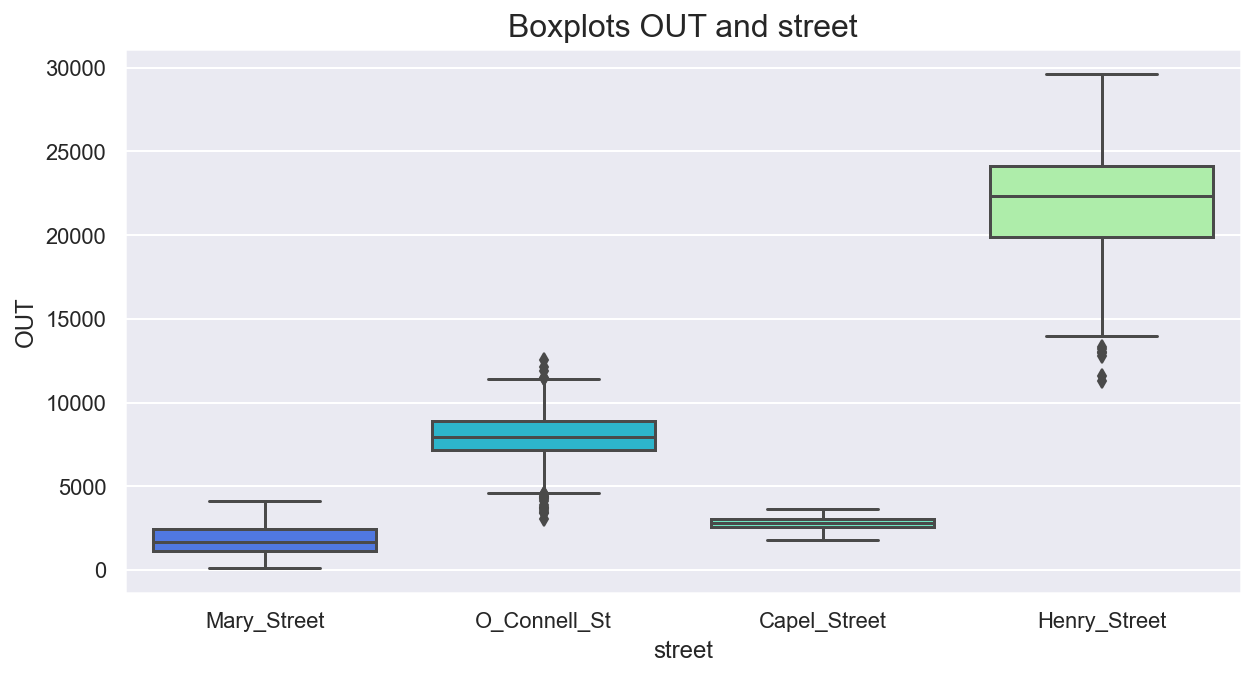

In [16]:
#set to seaborn
sns.set()
#palette
sns.set_palette('rainbow');
#plot size
plt.figure(figsize=(10, 5));   

sns.boxplot(x="street", y="OUT", data=dataset);
plt.title("Boxplots OUT and street", fontsize=16);

In [17]:
X = dataset.drop(['Date', 'street'], axis=1) # feature matrix 
feature_name = X.columns
y = dataset['street'] # target variable 
class_labels = np.unique(y)

## Splitting the dataset into the Training set and Test set

In [18]:
from sklearn.model_selection import train_test_split # Import train_test_split function [2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # 67% training and 33% test // found out by 1 - test_size = 1 - 0.33 = 0.67 -> 67%
X_train.shape, X_test.shape

((951, 12), (469, 12))

Because machine learning can only take input from numeric values so we need to factorise the data.

In [19]:
# decision trees like most machine learning algorithms cannot process labeled data values hence the data is encoded as numerical data is easily handled by this algorithm. 
import category_encoders as ce

encoder = ce.OrdinalEncoder(cols=['day', 
                                  'month', 'bank_holiday'])

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)


## Feature Scaling
For come of the columns there are some large numbers so I will apply feature scaling 

In [20]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Label encoding

In [21]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train= label_encoder.fit_transform(y_train)
y_test= label_encoder.fit_transform(y_test)

### Decision Tree
supervised learning, classification technique

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,explained_variance_score
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import accuracy_score

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [23]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df.head()

Actual  Predicted
0       1          1
1       2          2
2       0          0
3       0          0
4       0          0

In [24]:
# import classification report module
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
# Summary of the predictions with class names of the streets
print(classification_report(y_test,  y_pred, target_names=class_labels)) 

              precision    recall  f1-score   support

Capel_Street       0.76      0.83      0.80       132
Henry_Street       1.00      1.00      1.00       125
 Mary_Street       0.75      0.68      0.71       110
O_Connell_St       0.99      0.97      0.98       102

    accuracy                           0.87       469
   macro avg       0.88      0.87      0.87       469
weighted avg       0.87      0.87      0.87       469



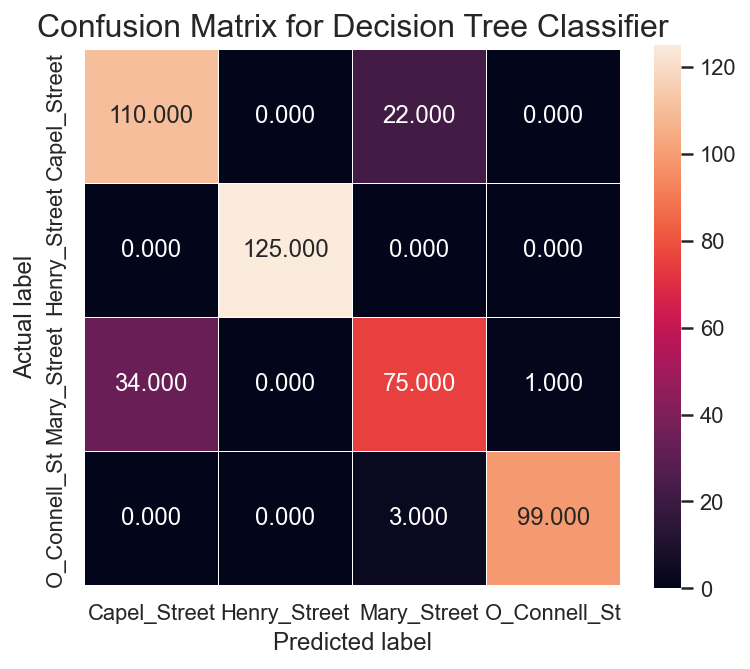

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
#set to seaborn
sns.set()
#palette
sns.set_palette('rainbow');
#plot size
plt.figure(figsize=(6, 5)); 

# Calculate cm by calling a method named as 'confusion_matrix'
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,index = class_labels, columns = class_labels)
# Call a method heatmap() to plot confusion matrix
sns.heatmap(cm_df, annot=True, fmt=".3f", linewidths=.5, square = True)

# Title and labels
plt.title("Confusion Matrix for Decision Tree Classifier", fontsize=16);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.show();

In [26]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("R-squared of the model in training set is: {}".format(clf.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(clf.score(X_test, y_test)))
print("Root mean squared error of the prediction is: {}".format(mse(y_test, y_pred)**(1/2)))

Accuracy: 0.8720682302771855
R-squared of the model in training set is: 1.0
-----Test set statistics-----
R-squared of the model in test set is: 0.8720682302771855
Root mean squared error of the prediction is: 0.6972379256370776


True

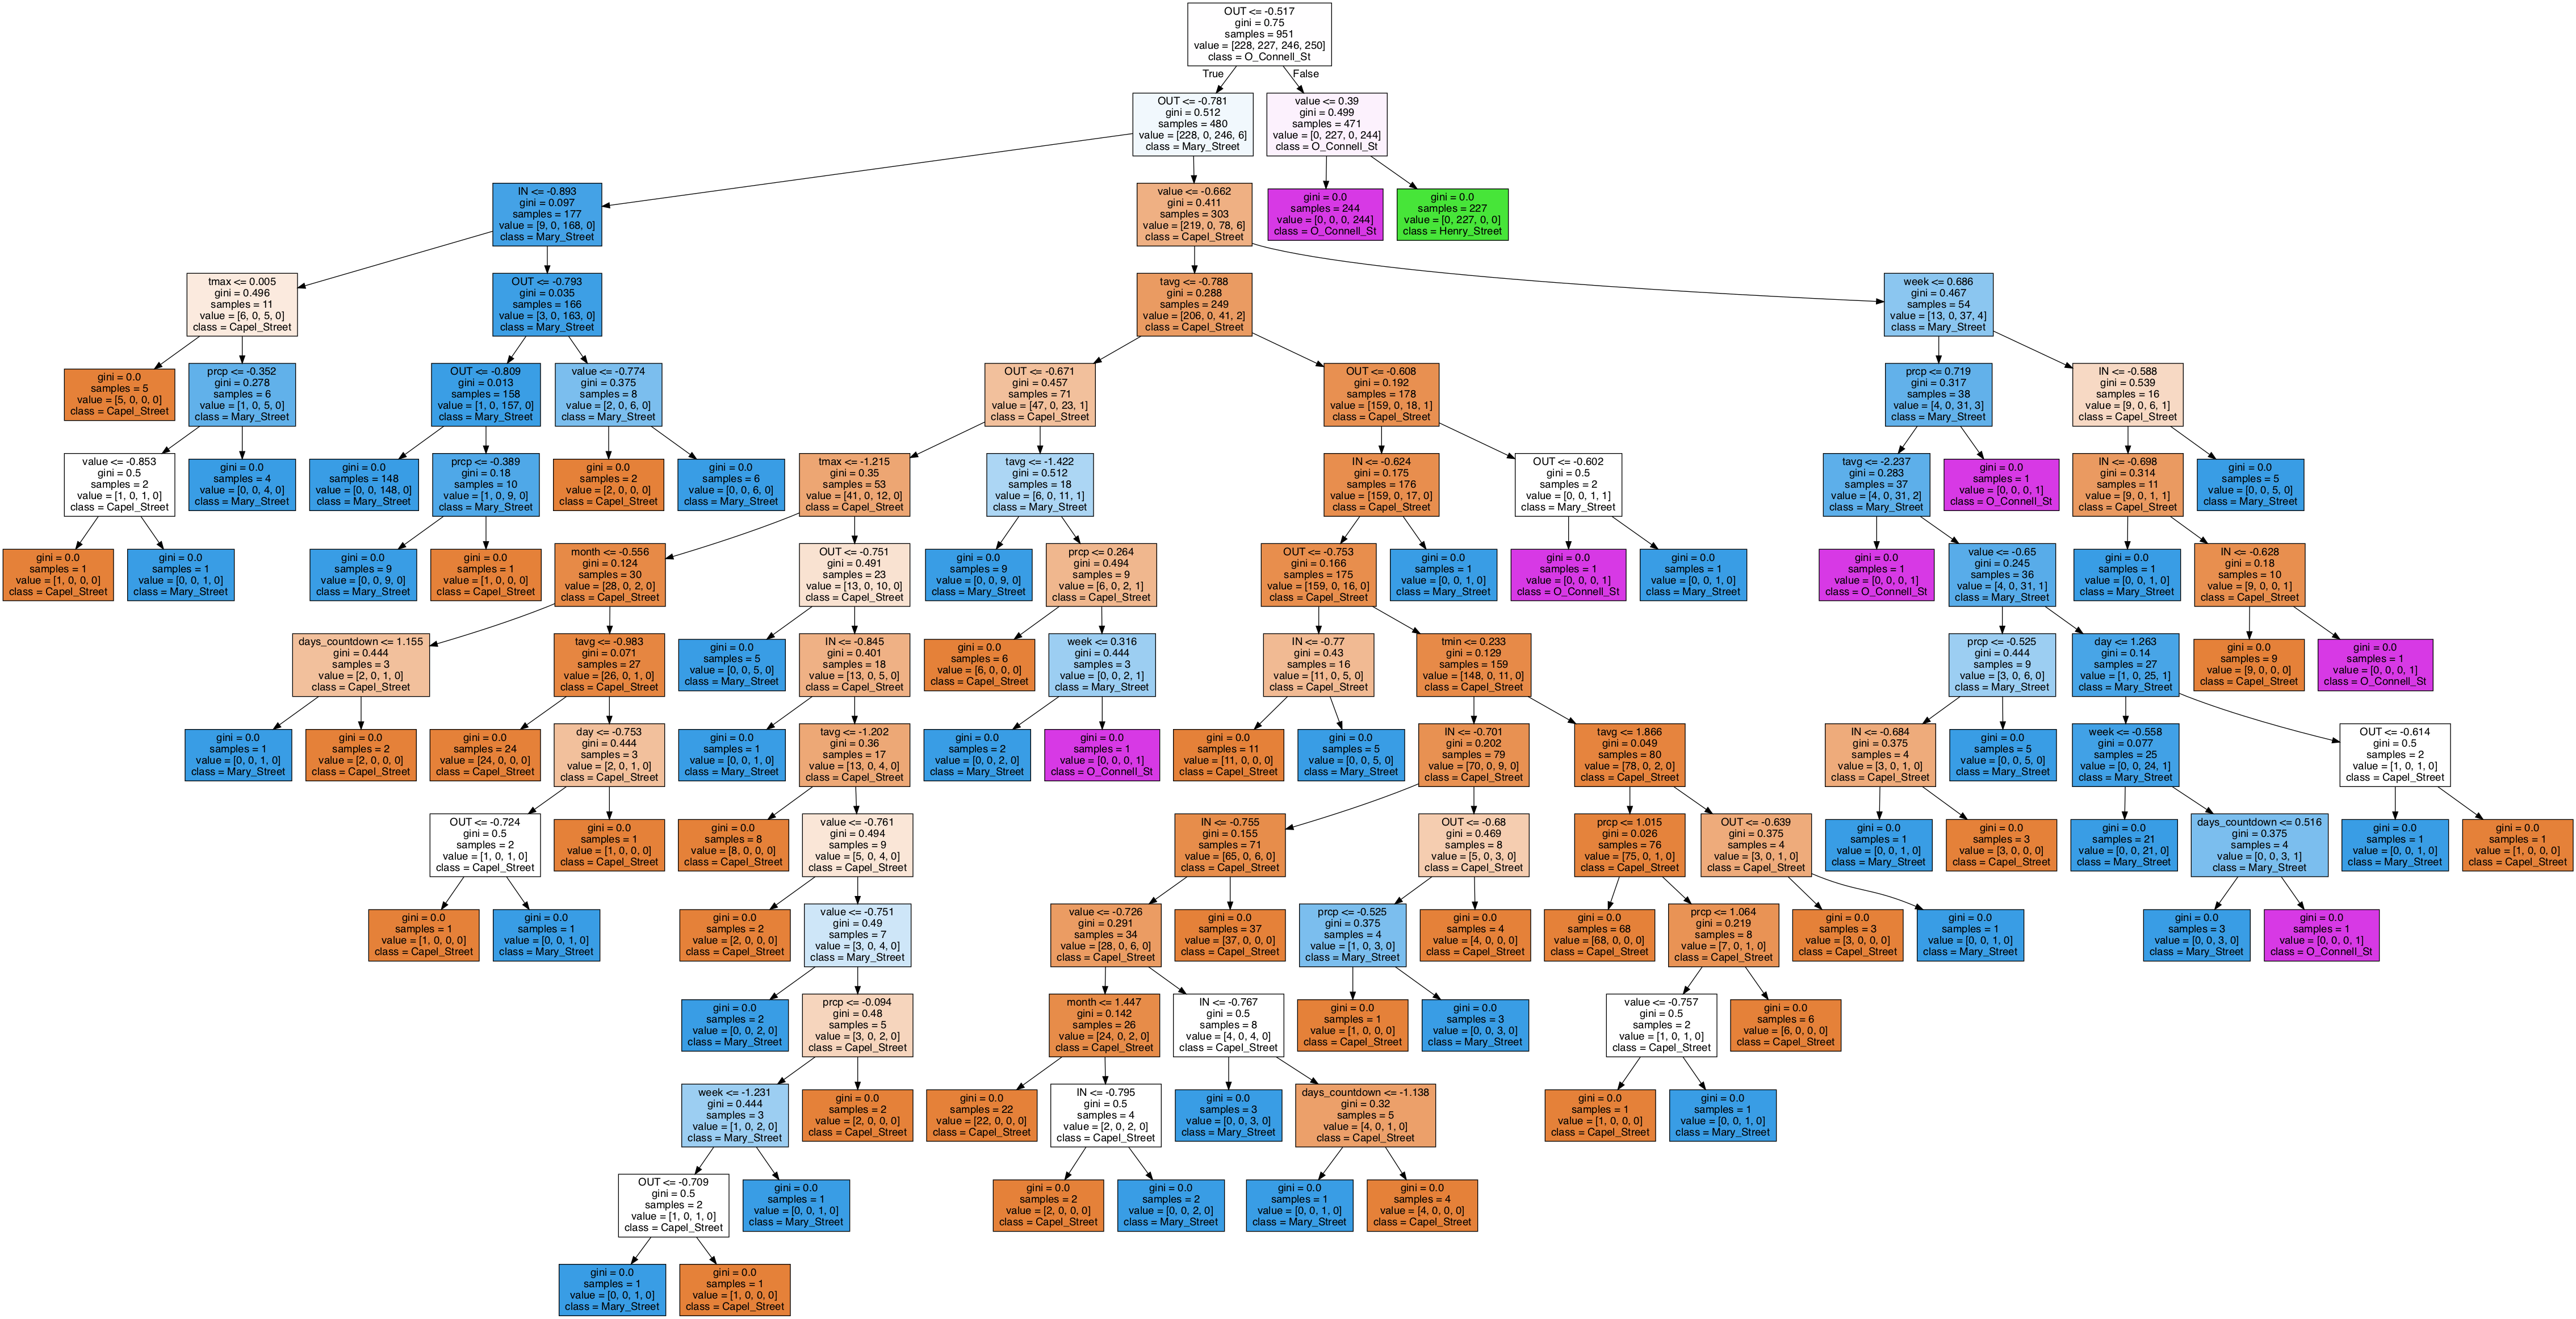

In [27]:
from sklearn.tree import export_graphviz
from sklearn import tree
from six import StringIO  
from IPython.display import Image  
import pydotplus
from pydotplus import graph_from_dot_data


dot_data = tree.export_graphviz(clf,filled=True, feature_names = feature_name, class_names=class_labels,out_file=None)

graph = pydotplus.graph_from_dot_data(dot_data)  
graph
graph.write_png('decision_tree.png')
Image(graph.create_png())

##### Feature importance

In [28]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index = feature_name).sort_values(ascending=False)
feature_imp

OUT               0.501847
value             0.382953
IN                0.045177
tavg              0.020148
prcp              0.018496
tmax              0.010264
week              0.009303
days_countdown    0.006220
month             0.003039
day               0.001671
tmin              0.000882
bank_holiday      0.000000
dtype: float64

##### Plotting feature importance

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


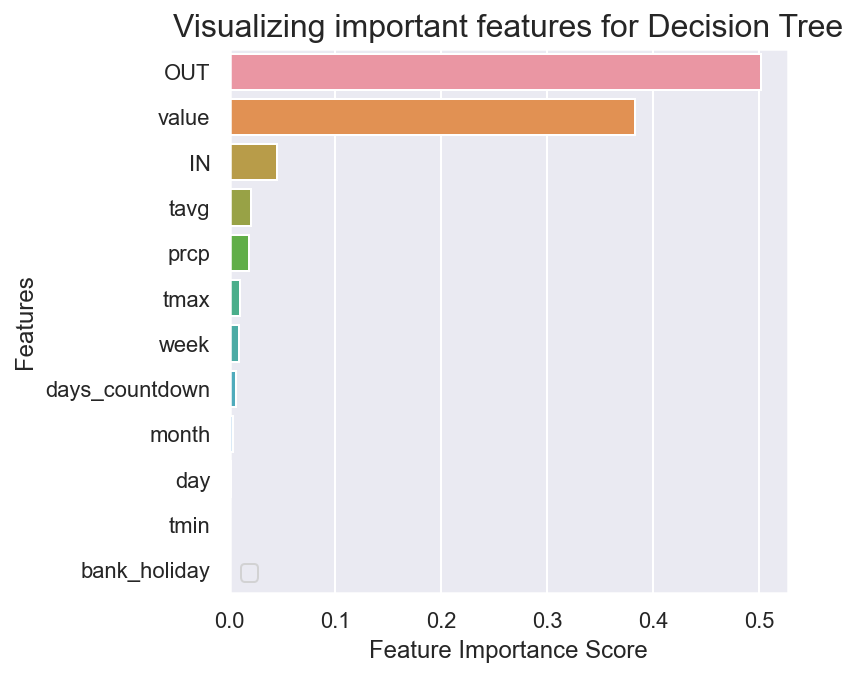

In [29]:
#set to seaborn
sns.set()
#palette
sns.set_palette('rainbow');
#plot size
plt.figure(figsize=(5, 5));   

sns.barplot(x=feature_imp, y=feature_imp.index);
# Add labels to your graph
plt.xlabel('Feature Importance Score');
plt.ylabel('Features');
plt.title("Visualizing important features for Decision Tree", fontsize=16);
plt.legend();
plt.show();

### Random Forest
Supervised learning technique, classification technique


In [30]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# n_estimatorsint, default=100 trees in the forest
rfc = RandomForestClassifier()

#Train the model using the training sets y_pred=clf.predict(X_test)
rfc.fit(X_train,y_train)

#After training we can perform prediction on the test data.
y_pred = rfc.predict(X_test)

RandomForestClassifier()

In [31]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df.head()

Actual  Predicted
0       1          1
1       2          0
2       0          0
3       0          0
4       0          0

In [32]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9147121535181236


True

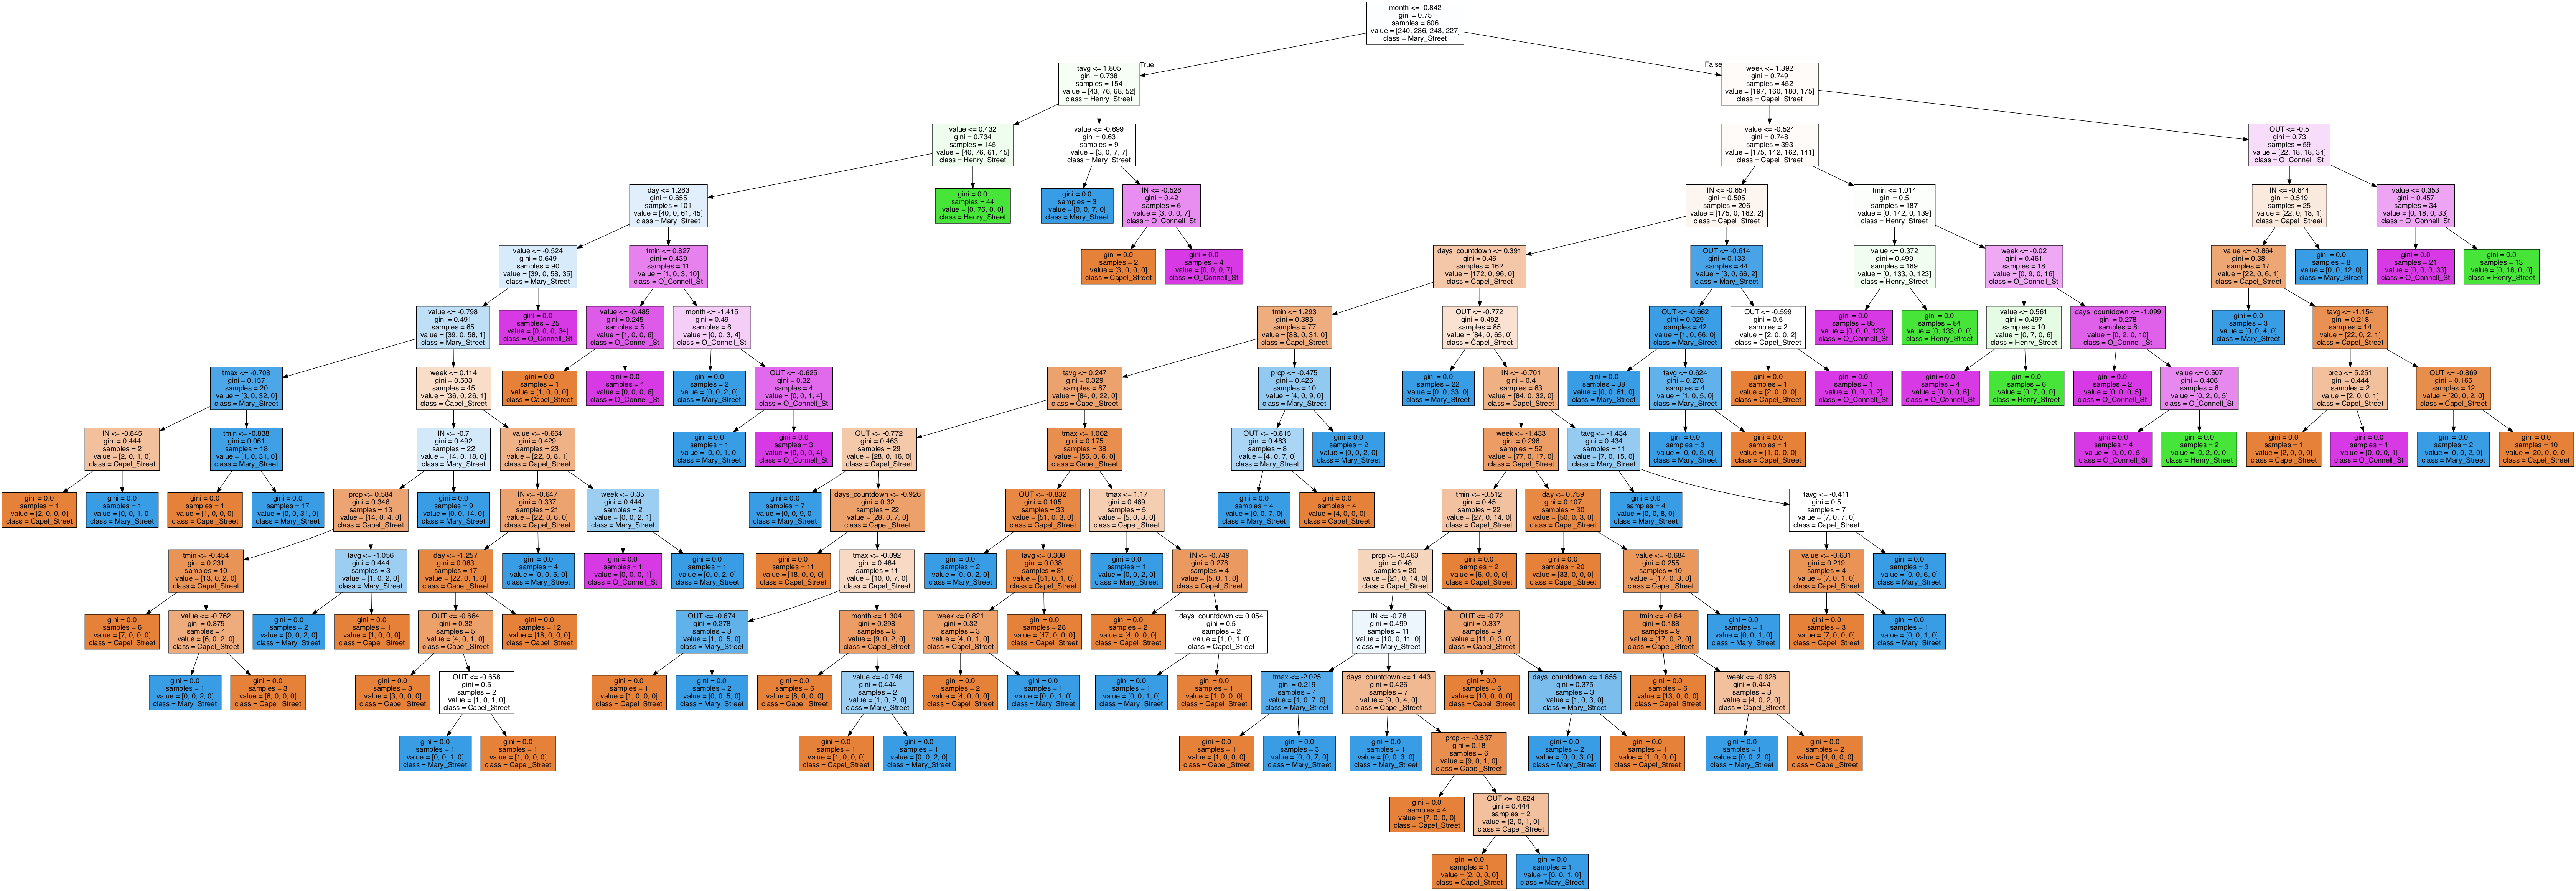

In [33]:
#libraries to show the tree visualisation
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus
from pydotplus import graph_from_dot_data

i_tree = 0

dot_data = StringIO()

#loop rfc random forest classifier
for tree_in_forest in rfc.estimators_: 
    if (i_tree ==3):        
        export_graphviz(tree_in_forest,filled=True, out_file=dot_data, feature_names = feature_name, class_names=class_labels)
        graph = pydotplus.graph_from_dot_data(dot_data.getvalue())        
    i_tree = i_tree + 1

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph
graph.write_png('RandomForest.png')
Image(graph.create_png())

##### Classification Report

In [34]:
# import the library classification_report
from sklearn.metrics import classification_report

# Display the report with street names
print(classification_report(y_test, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

Capel_Street       0.82      0.92      0.87       132
Henry_Street       1.00      1.00      1.00       125
 Mary_Street       0.86      0.75      0.81       110
O_Connell_St       1.00      0.97      0.99       102

    accuracy                           0.91       469
   macro avg       0.92      0.91      0.91       469
weighted avg       0.92      0.91      0.91       469



##### Confusion Matrix

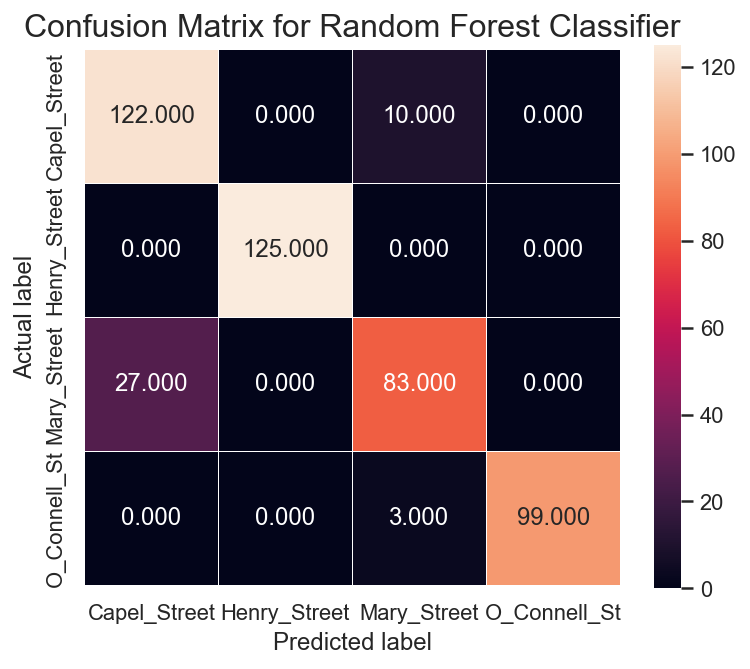

In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

#set to seaborn
sns.set()
#palette
sns.set_palette('rainbow');
#plot size
plt.figure(figsize=(6, 5)); 

# Calculate cm by calling a method named as 'confusion_matrix'
cm = confusion_matrix(y_test, y_pred)

#adding in the names for the streets 
cm_df = pd.DataFrame(cm,index = class_labels, columns = class_labels)
# Call a method heatmap() to plot confusion matrix
sns.heatmap(cm_df, annot=True, fmt=".3f", linewidths=.5, square = True)


# Title and labels
plt.title("Confusion Matrix for Random Forest Classifier", fontsize=16);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.show();


##### Feature importance

In [36]:
import pandas as pd
feature_imp = pd.Series(rfc.feature_importances_,index = feature_name).sort_values(ascending=False)
feature_imp

OUT               0.374142
value             0.277835
IN                0.246157
days_countdown    0.016059
tmax              0.014881
tavg              0.014804
tmin              0.014598
week              0.013381
prcp              0.013192
month             0.007054
day               0.006897
bank_holiday      0.000999
dtype: float64

##### Plotting feature importance for random forest

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


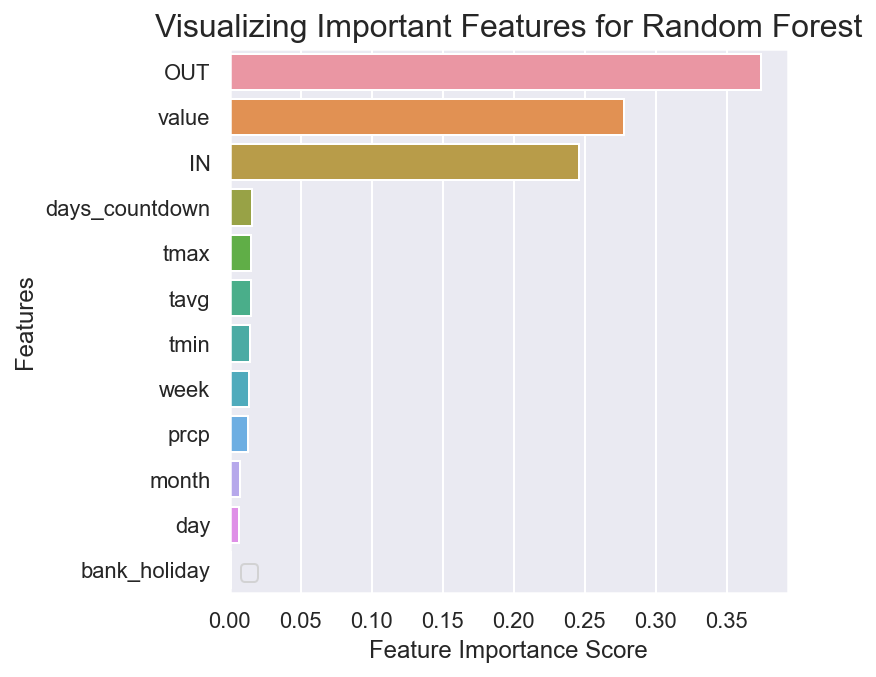

In [37]:
#set to seaborn
sns.set()
#palette
sns.set_palette('rainbow');
#plot size
plt.figure(figsize=(5, 5));   

sns.barplot(x=feature_imp, y=feature_imp.index);
# Add labels to your graph
plt.xlabel('Feature Importance Score');
plt.ylabel('Features');
plt.title("Visualizing Important Features for Random Forest", fontsize=16);
plt.legend();
plt.show();

### k-nearest neighbors 

In [38]:
from sklearn.neighbors import KNeighborsClassifier
# number of neighbors
neighbors = np.arange(1, 150)  
train_accuracy = np.zeros(len(neighbors))    
test_accuracy = np.zeros(len(neighbors))     

#loops through neighbors
for i,k in enumerate(neighbors):                          
    knn = KNeighborsClassifier(n_neighbors = k)           

    #Train the model
    knn.fit(X_train, y_train)                     

    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)   

    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test)      

KNeighborsClassifier(n_neighbors=1)

KNeighborsClassifier(n_neighbors=2)

KNeighborsClassifier(n_neighbors=3)

KNeighborsClassifier(n_neighbors=4)

KNeighborsClassifier()

KNeighborsClassifier(n_neighbors=6)

KNeighborsClassifier(n_neighbors=7)

KNeighborsClassifier(n_neighbors=8)

KNeighborsClassifier(n_neighbors=9)

KNeighborsClassifier(n_neighbors=10)

KNeighborsClassifier(n_neighbors=11)

KNeighborsClassifier(n_neighbors=12)

KNeighborsClassifier(n_neighbors=13)

KNeighborsClassifier(n_neighbors=14)

KNeighborsClassifier(n_neighbors=15)

KNeighborsClassifier(n_neighbors=16)

KNeighborsClassifier(n_neighbors=17)

KNeighborsClassifier(n_neighbors=18)

KNeighborsClassifier(n_neighbors=19)

KNeighborsClassifier(n_neighbors=20)

KNeighborsClassifier(n_neighbors=21)

KNeighborsClassifier(n_neighbors=22)

KNeighborsClassifier(n_neighbors=23)

KNeighborsClassifier(n_neighbors=24)

KNeighborsClassifier(n_neighbors=25)

KNeighborsClassifier(n_neighbors=26)

KNeighborsClassifier(n_neighbors=27)

KNeighborsClassifier(n_neighbors=28)

KNeighborsClassifier(n_neighbors=29)

KNeighborsClassifier(n_neighbors=30)

KNeighborsClassifier(n_neighbors=31)

KNeighborsClassifier(n_neighbors=32)

KNeighborsClassifier(n_neighbors=33)

KNeighborsClassifier(n_neighbors=34)

KNeighborsClassifier(n_neighbors=35)

KNeighborsClassifier(n_neighbors=36)

KNeighborsClassifier(n_neighbors=37)

KNeighborsClassifier(n_neighbors=38)

KNeighborsClassifier(n_neighbors=39)

KNeighborsClassifier(n_neighbors=40)

KNeighborsClassifier(n_neighbors=41)

KNeighborsClassifier(n_neighbors=42)

KNeighborsClassifier(n_neighbors=43)

KNeighborsClassifier(n_neighbors=44)

KNeighborsClassifier(n_neighbors=45)

KNeighborsClassifier(n_neighbors=46)

KNeighborsClassifier(n_neighbors=47)

KNeighborsClassifier(n_neighbors=48)

KNeighborsClassifier(n_neighbors=49)

KNeighborsClassifier(n_neighbors=50)

KNeighborsClassifier(n_neighbors=51)

KNeighborsClassifier(n_neighbors=52)

KNeighborsClassifier(n_neighbors=53)

KNeighborsClassifier(n_neighbors=54)

KNeighborsClassifier(n_neighbors=55)

KNeighborsClassifier(n_neighbors=56)

KNeighborsClassifier(n_neighbors=57)

KNeighborsClassifier(n_neighbors=58)

KNeighborsClassifier(n_neighbors=59)

KNeighborsClassifier(n_neighbors=60)

KNeighborsClassifier(n_neighbors=61)

KNeighborsClassifier(n_neighbors=62)

KNeighborsClassifier(n_neighbors=63)

KNeighborsClassifier(n_neighbors=64)

KNeighborsClassifier(n_neighbors=65)

KNeighborsClassifier(n_neighbors=66)

KNeighborsClassifier(n_neighbors=67)

KNeighborsClassifier(n_neighbors=68)

KNeighborsClassifier(n_neighbors=69)

KNeighborsClassifier(n_neighbors=70)

KNeighborsClassifier(n_neighbors=71)

KNeighborsClassifier(n_neighbors=72)

KNeighborsClassifier(n_neighbors=73)

KNeighborsClassifier(n_neighbors=74)

KNeighborsClassifier(n_neighbors=75)

KNeighborsClassifier(n_neighbors=76)

KNeighborsClassifier(n_neighbors=77)

KNeighborsClassifier(n_neighbors=78)

KNeighborsClassifier(n_neighbors=79)

KNeighborsClassifier(n_neighbors=80)

KNeighborsClassifier(n_neighbors=81)

KNeighborsClassifier(n_neighbors=82)

KNeighborsClassifier(n_neighbors=83)

KNeighborsClassifier(n_neighbors=84)

KNeighborsClassifier(n_neighbors=85)

KNeighborsClassifier(n_neighbors=86)

KNeighborsClassifier(n_neighbors=87)

KNeighborsClassifier(n_neighbors=88)

KNeighborsClassifier(n_neighbors=89)

KNeighborsClassifier(n_neighbors=90)

KNeighborsClassifier(n_neighbors=91)

KNeighborsClassifier(n_neighbors=92)

KNeighborsClassifier(n_neighbors=93)

KNeighborsClassifier(n_neighbors=94)

KNeighborsClassifier(n_neighbors=95)

KNeighborsClassifier(n_neighbors=96)

KNeighborsClassifier(n_neighbors=97)

KNeighborsClassifier(n_neighbors=98)

KNeighborsClassifier(n_neighbors=99)

KNeighborsClassifier(n_neighbors=100)

KNeighborsClassifier(n_neighbors=101)

KNeighborsClassifier(n_neighbors=102)

KNeighborsClassifier(n_neighbors=103)

KNeighborsClassifier(n_neighbors=104)

KNeighborsClassifier(n_neighbors=105)

KNeighborsClassifier(n_neighbors=106)

KNeighborsClassifier(n_neighbors=107)

KNeighborsClassifier(n_neighbors=108)

KNeighborsClassifier(n_neighbors=109)

KNeighborsClassifier(n_neighbors=110)

KNeighborsClassifier(n_neighbors=111)

KNeighborsClassifier(n_neighbors=112)

KNeighborsClassifier(n_neighbors=113)

KNeighborsClassifier(n_neighbors=114)

KNeighborsClassifier(n_neighbors=115)

KNeighborsClassifier(n_neighbors=116)

KNeighborsClassifier(n_neighbors=117)

KNeighborsClassifier(n_neighbors=118)

KNeighborsClassifier(n_neighbors=119)

KNeighborsClassifier(n_neighbors=120)

KNeighborsClassifier(n_neighbors=121)

KNeighborsClassifier(n_neighbors=122)

KNeighborsClassifier(n_neighbors=123)

KNeighborsClassifier(n_neighbors=124)

KNeighborsClassifier(n_neighbors=125)

KNeighborsClassifier(n_neighbors=126)

KNeighborsClassifier(n_neighbors=127)

KNeighborsClassifier(n_neighbors=128)

KNeighborsClassifier(n_neighbors=129)

KNeighborsClassifier(n_neighbors=130)

KNeighborsClassifier(n_neighbors=131)

KNeighborsClassifier(n_neighbors=132)

KNeighborsClassifier(n_neighbors=133)

KNeighborsClassifier(n_neighbors=134)

KNeighborsClassifier(n_neighbors=135)

KNeighborsClassifier(n_neighbors=136)

KNeighborsClassifier(n_neighbors=137)

KNeighborsClassifier(n_neighbors=138)

KNeighborsClassifier(n_neighbors=139)

KNeighborsClassifier(n_neighbors=140)

KNeighborsClassifier(n_neighbors=141)

KNeighborsClassifier(n_neighbors=142)

KNeighborsClassifier(n_neighbors=143)

KNeighborsClassifier(n_neighbors=144)

KNeighborsClassifier(n_neighbors=145)

KNeighborsClassifier(n_neighbors=146)

KNeighborsClassifier(n_neighbors=147)

KNeighborsClassifier(n_neighbors=148)

KNeighborsClassifier(n_neighbors=149)

In [39]:
df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df.head()

Actual  Predicted
0       1          1
1       2          0
2       0          0
3       0          0
4       0          0

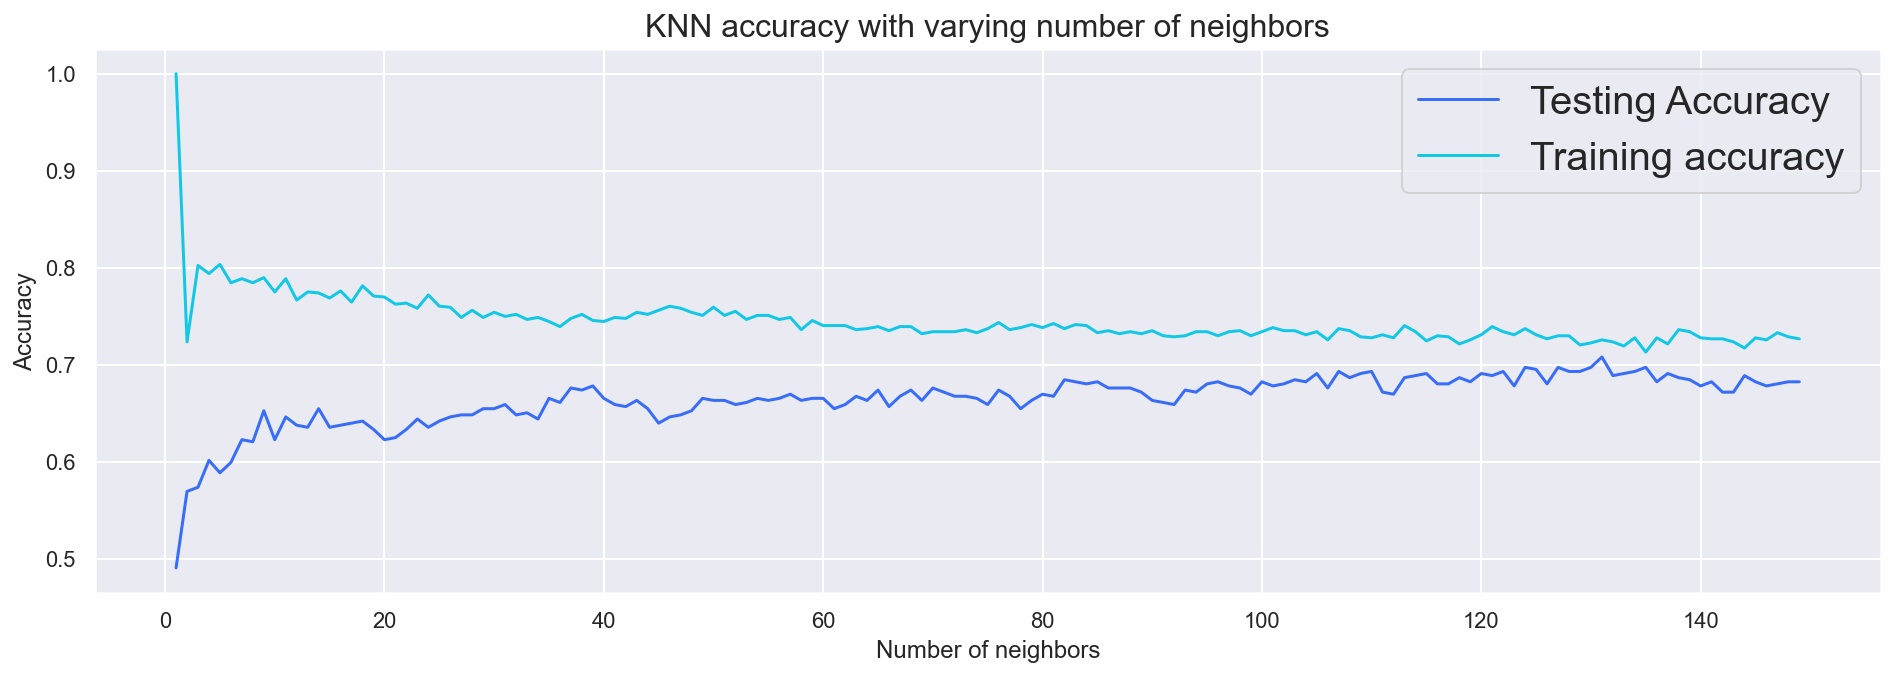

In [40]:
#set to seaborn
sns.set()
#palette
sns.set_palette('rainbow');
#plot size
plt.figure(figsize=(16, 5)); 

plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy');
plt.plot(neighbors, train_accuracy, label = 'Training accuracy');

plt.title('KNN accuracy with varying number of neighbors', fontsize = 16);
plt.legend(prop = {'size': 20});
plt.xlabel('Number of neighbors');
plt.ylabel('Accuracy');
#plt.xticks(fontsize = 20)
#plt.yticks(fontsize = 20)
plt.show();

In [41]:
# around 31 seems to the best accuracy, looking at the chart above
knn = KNeighborsClassifier(n_neighbors = 31)

# Fit the model
knn.fit(X_train, y_train)

# Compute accuracy on the training set
train_accuracy = knn.score(X_train, y_train)

# Compute accuracy on the test set
test_accuracy = knn.score(X_test, y_test)

# Display the test accuracy
print('KNN Accuracy', test_accuracy)

KNeighborsClassifier(n_neighbors=31)

KNN Accuracy 0.6588486140724946


##### Classification Report
Classification report helps us in identifying the misclassified classes in much more detail by giving precision, recall and F1 score for each class. We use the sklearn library to visualize the classification report.

In [42]:
# import the library classification_report
from sklearn.metrics import classification_report

# Display the report with street names
print(classification_report(y_test, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

Capel_Street       0.82      0.92      0.87       132
Henry_Street       1.00      1.00      1.00       125
 Mary_Street       0.86      0.75      0.81       110
O_Connell_St       1.00      0.97      0.99       102

    accuracy                           0.91       469
   macro avg       0.92      0.91      0.91       469
weighted avg       0.92      0.91      0.91       469



##### Confusion matrix

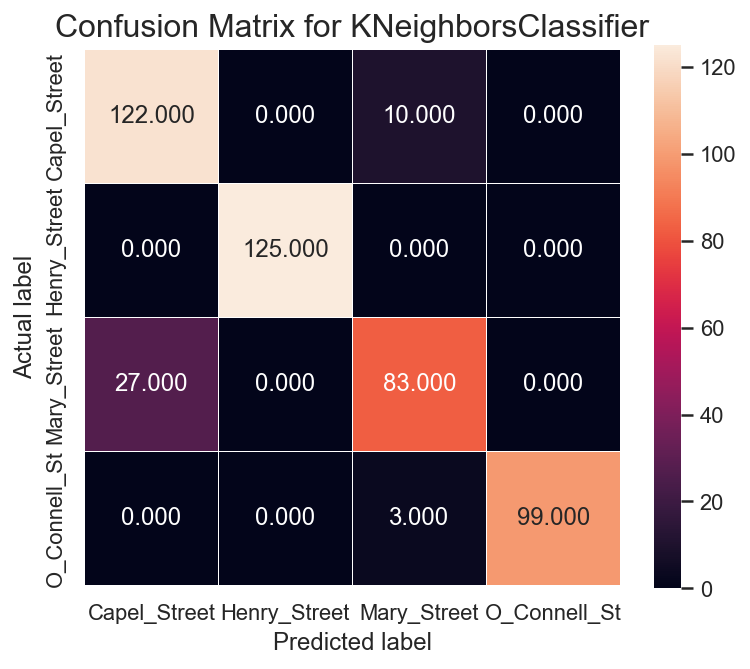

In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

#set to seaborn
sns.set()
#palette
sns.set_palette('rainbow');
#plot size
plt.figure(figsize=(6, 5)); 

# Calculate cm by calling a method named as 'confusion_matrix'
cm = confusion_matrix(y_test, y_pred)

#adding in the names for the streets 
cm_df = pd.DataFrame(cm,index = class_labels, columns = class_labels)
# Call a method heatmap() to plot confusion matrix
sns.heatmap(cm_df, annot=True, fmt=".3f", linewidths=.5, square = True)


# Title and labels
plt.title("Confusion Matrix for KNeighborsClassifier", fontsize=16);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.show();

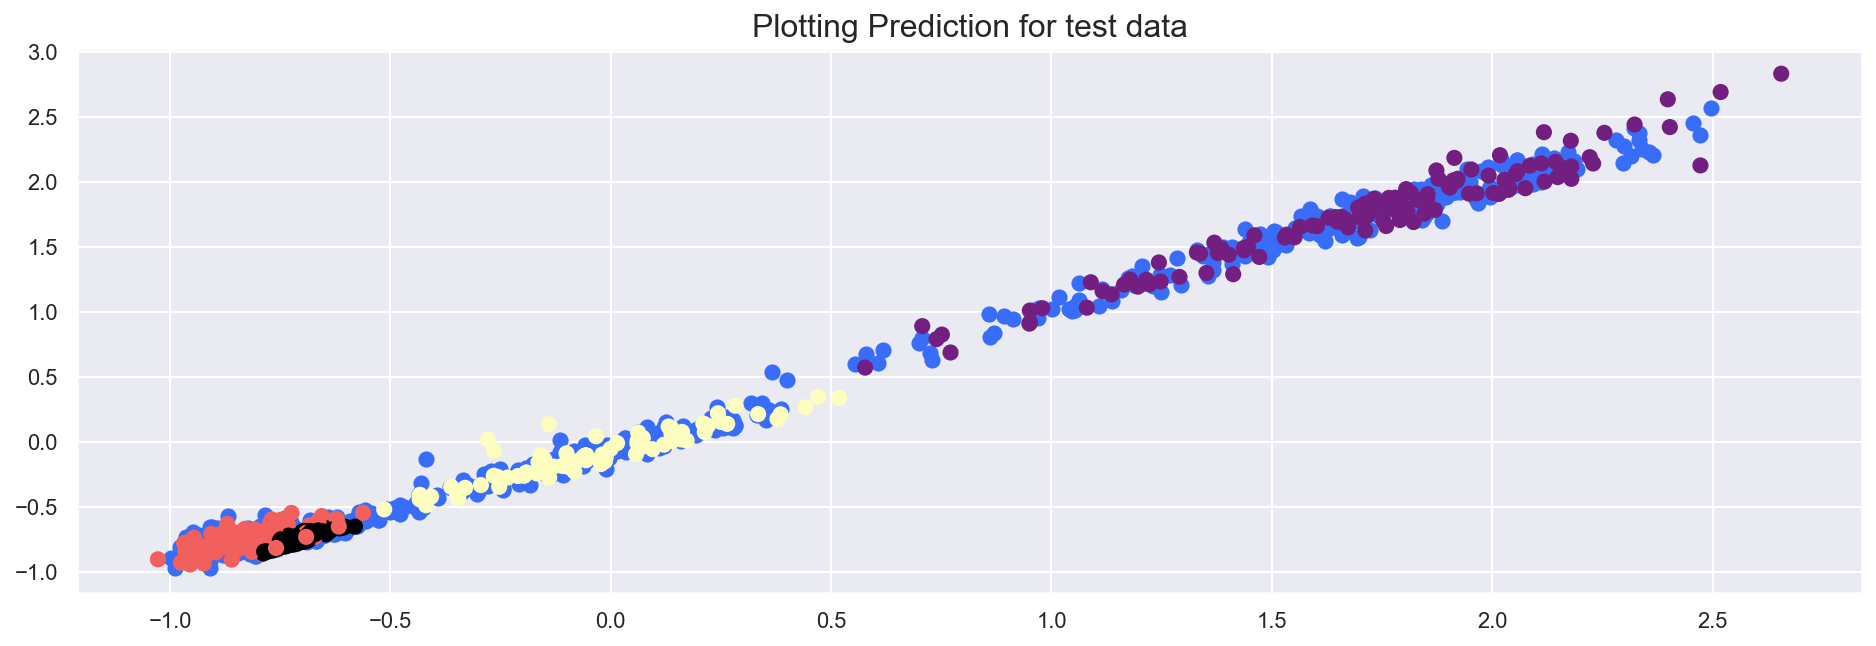

In [44]:
#set to seaborn
sns.set()
#palette
sns.set_palette('rainbow');
#plot size
plt.figure(figsize=(16, 5)); 

#training data in blue
plt.scatter(X_train[:, 1], X_train[:, 2], s=50);

# test data in magma palette
plt.scatter(X_test[:, 1], X_test[:, 2], c=y_pred, s=50, cmap= 'magma');

plt.title("Plotting Prediction for test data", fontsize=16)
plt.show();


### Logistic regression 
Logistic regression is a supervised method where works for both classification and regression 

In [45]:
#Import logistic regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

#Train the model using the training sets y_pred=clf.predict(X_test)
logreg.fit(X_train,y_train)

#After training we can perform prediction on the test data.
y_pred = logreg.predict(X_test)

LogisticRegression()

#### measure performance


In [46]:
#https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

import math

print("mean_squared_error:", mean_squared_error(y_test, y_pred))
print("Root Mean Square Error(RMSE):", math.sqrt(mean_squared_error(y_test, y_pred)))
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
score = logreg.score(X_test, y_test)
print("Accuracy score:", score)
print("coefficients shape: ", logreg.coef_.shape)
print("intercept shape: ", logreg.intercept_.shape)

#explained_variance_score Best possible score is 1.0, lower values are worse.
print("Explained variance score: %.2f" % explained_variance_score(y_test, y_pred))

mean_squared_error: 0.2942430703624733
Root Mean Square Error(RMSE): 0.5424417667938867
Mean squared error: 0.29
Coefficient of determination: 0.76
Accuracy score: 0.9275053304904051
coefficients shape:  (4, 12)
intercept shape:  (4,)
Explained variance score: 0.77


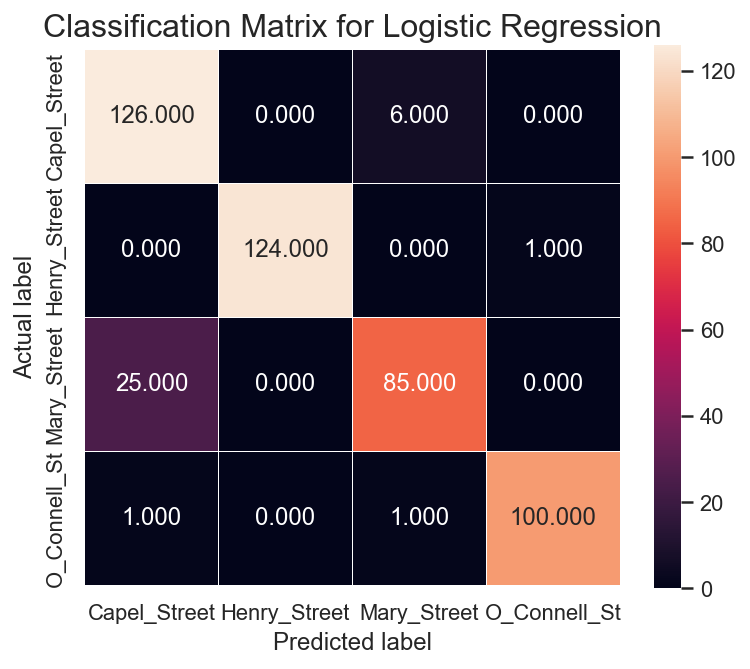

In [47]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

#set to seaborn
sns.set()
#palette
sns.set_palette('rainbow');
#plot size
plt.figure(figsize=(6, 5)); 


# Calculate cm by calling a method named as 'confusion_matrix'
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,index = class_labels, columns = class_labels)
# Call a method heatmap() to plot confusion matrix
sns.heatmap(cm_df,annot=True, fmt=".3f", linewidths=.5, square = True )

# Title and labels
plt.title("Classification Matrix for Logistic Regression", fontsize=16);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.show();

In [48]:
# import the library classification_report
from sklearn.metrics import classification_report

# Display the report with street names
print(classification_report(y_test, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

Capel_Street       0.83      0.95      0.89       132
Henry_Street       1.00      0.99      1.00       125
 Mary_Street       0.92      0.77      0.84       110
O_Connell_St       0.99      0.98      0.99       102

    accuracy                           0.93       469
   macro avg       0.94      0.92      0.93       469
weighted avg       0.93      0.93      0.93       469



##### Feature Importance in logistics regression is a bit different

In [49]:
log_odds = logreg.coef_[0]

log_feature = pd.DataFrame(log_odds, 
             X.columns, 
             columns=['coef'])\
            .sort_values(by='coef', ascending=False)

log_feature 

coef
OUT             0.880907
month           0.220587
tavg            0.188504
week            0.080701
tmax            0.061249
days_countdown  0.023727
day             0.005040
tmin           -0.073260
bank_holiday   -0.113977
prcp           -0.189838
value          -2.282047
IN             -5.910936

In [50]:
import pandas as pd

log_odds = logreg.coef_[0]


log_feature = pd.Series(log_odds ,index = feature_name).sort_values(ascending=False)
log_feature

OUT               0.880907
month             0.220587
tavg              0.188504
week              0.080701
tmax              0.061249
days_countdown    0.023727
day               0.005040
tmin             -0.073260
bank_holiday     -0.113977
prcp             -0.189838
value            -2.282047
IN               -5.910936
dtype: float64

##### Plotting Feature importance

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


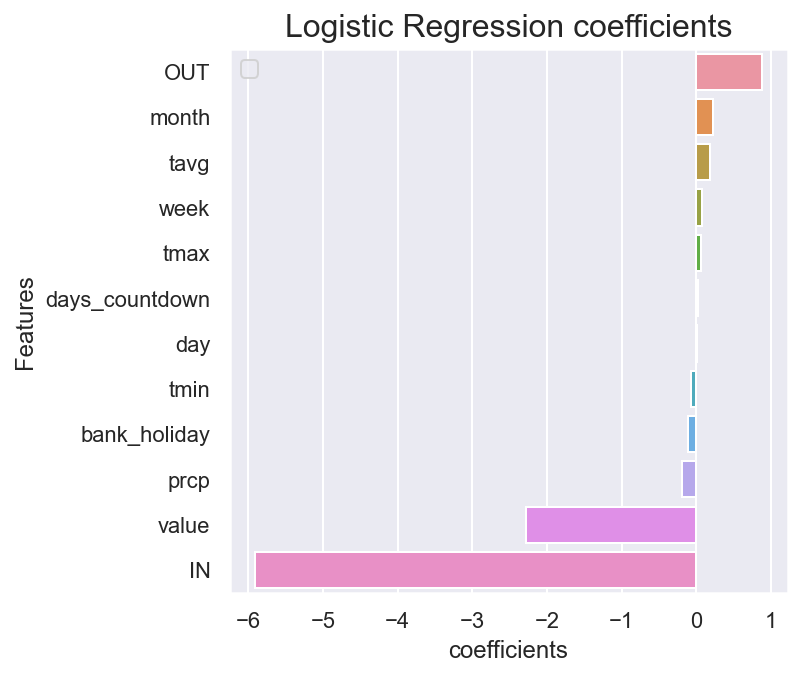

In [51]:
#set to seaborn
sns.set()
#palette
sns.set_palette('rainbow');
#plot size
plt.figure(figsize=(5, 5));   

sns.barplot(x=log_feature, y=log_feature.index);
# Add labels to your graph
plt.xlabel('coefficients');
plt.ylabel('Features');
plt.title("Logistic Regression coefficients", fontsize=16);
plt.legend();
plt.show();

#  Clustering 
## K-means clustering

In [52]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans

# taking columns IN and OUT
x = dataset.iloc[:,1:3]

kmeans = KMeans(4)
kmeans.fit(x)


KMeans(n_clusters=4)

In [53]:
identified_clusters = kmeans.fit_predict(x)
identified_clusters

array([0, 0, 0, ..., 3, 0, 2], dtype=int32)

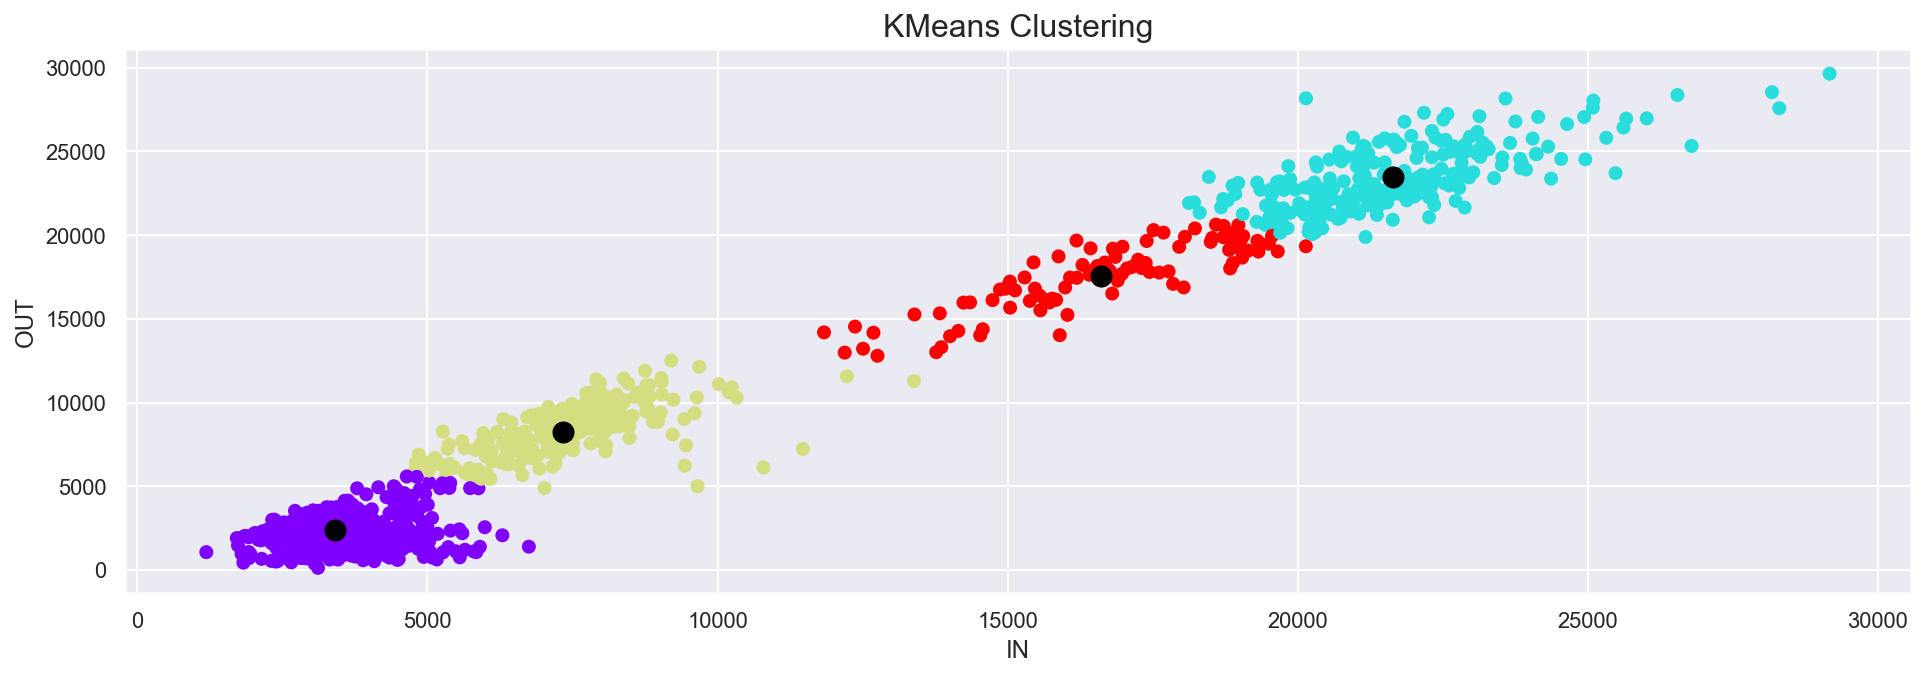

In [54]:
#set to seaborn
sns.set();
#palette
sns.set_palette('rainbow');
#plot size
plt.figure(figsize=(16, 5)); 


data_with_clusters = dataset.copy()
data_with_clusters['Clusters'] = identified_clusters 
plt.scatter(data_with_clusters['IN'],data_with_clusters['OUT'],c=data_with_clusters['Clusters'],cmap='rainbow');
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'black', label = 'Centroids')
# Title and labels
plt.title("KMeans Clustering",fontsize=16);
plt.xlabel('IN');
plt.ylabel('OUT');

## Trying different method ( to find no .of clusters to be selected

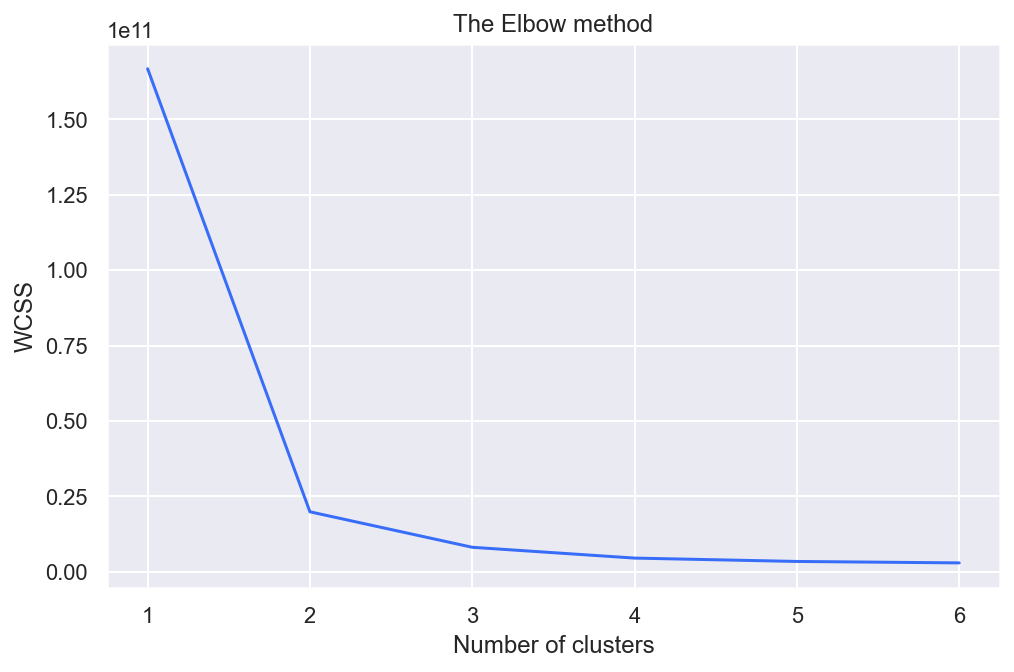

In [55]:
#set to seaborn
sns.set()
#palette
sns.set_palette('rainbow');
#plot size
plt.figure(figsize=(8, 5)); 

wcss=[]
for i in range(1,7):
    kmeans = KMeans(i)
    kmeans.fit(x)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,7)
plt.plot(number_clusters,wcss);
plt.title('The Elbow method');
plt.xlabel('Number of clusters');
plt.ylabel('WCSS');

We can choose 4 clusters

# GridSearch cv
Grid search allows you to quickly find the best parameters for your model.

In [56]:
print('Parameters currently in use:\n')
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


rforest = RandomForestClassifier(random_state=42)

print(rforest.get_params())

Parameters currently in use:

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [57]:
# parameters for Random forest
param_grid = {    
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
              }

print(param_grid)

{'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}


In [58]:
rf_random = GridSearchCV(estimator=rforest, param_grid=param_grid, cv= 5)
# Fit the random search model
rf_random.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

In [59]:
rf_random.cv_results_

{'mean_fit_time': array([0.3523489 , 0.85087509, 0.31024833, 0.82641945, 0.33730373,
        0.85503168, 0.34604301, 0.88103876, 0.32553267, 0.83802347,
        0.34455109, 0.85077701, 0.34279799, 0.91220446, 0.3391789 ,
        0.8676569 , 0.35196624, 0.86386375, 0.35939541, 0.89265366,
        0.35164509, 0.89376421, 0.34542723, 0.86289911, 0.35621104,
        0.89853811, 0.351685  , 0.88249297, 0.34448471, 0.84534478,
        0.34243364, 0.85295262, 0.3420217 , 0.98983264, 0.36397948,
        0.92771783, 0.36377439, 0.91287384, 0.43661361, 0.96808167,
        0.3582273 , 0.92730842, 0.38479605, 1.0147666 , 0.38281178,
        1.12412977, 0.42336063, 1.02681174, 0.39874897, 1.06699872,
        0.43112421, 1.10762   , 0.39480343, 0.98137321, 0.40089993,
        1.0027967 , 0.40015607, 0.99864473, 0.40179558, 1.01205711]),
 'std_fit_time': array([0.02018293, 0.06218671, 0.0015435 , 0.04354477, 0.0117356 ,
        0.05428064, 0.00558821, 0.03158085, 0.00328109, 0.04598622,
        0.017

In [60]:
# view results in a table
df = pd.DataFrame(rf_random.cv_results_)
df

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.352349      0.020183         0.022720        0.002562   
1        0.850875      0.062187         0.059135        0.012052   
2        0.310248      0.001544         0.020528        0.000311   
3        0.826419      0.043545         0.053974        0.004495   
4        0.337304      0.011736         0.024047        0.001572   
5        0.855032      0.054281         0.058087        0.005525   
6        0.346043      0.005588         0.023400        0.001249   
7        0.881039      0.031581         0.054746        0.001528   
8        0.325533      0.003281         0.021148        0.000258   
9        0.838023      0.045986         0.057152        0.007292   
10       0.344551      0.017441         0.022279        0.001214   
11       0.850777      0.018896         0.053763        0.002449   
12       0.342798      0.002871         0.022508        0.001487   
13       0.912204      0.060605         0.055860        0.004992   
14       0.339179      0.006145         0.021993        0.001074   
15       0.867657      0.007951         0.055389        0.000681   
16       0.351966      0.012339         0.022619        0.000829   
17       0.863864      0.019448         0.056008        0.003152   
18       0.359395      0.011283         0.022680        0.000954   
19       0.892654      0.015102         0.056522        0.002444   
20       0.351645      0.003785         0.022670        0.000755   
21       0.893764      0.010578         0.056103        0.000772   
22       0.345427      0.003892         0.021888        0.000653   
23       0.862899      0.009831         0.053817        0.002879   
24       0.356211      0.008889         0.022404        0.000638   
25       0.898538      0.035281         0.057181        0.001140   
26       0.351685      0.007951         0.022263        0.001136   
27       0.882493      0.012379         0.053087        0.001318   
28       0.344485      0.005719         0.022164        0.000586   
29       0.845345      0.003277         0.052280        0.000293   
30       0.342434      0.001174         0.021074        0.000778   
31       0.852953      0.001417         0.062953        0.025441   
32       0.342022      0.001488         0.021076        0.000536   
33       0.989833      0.093241         0.060601        0.014797   
34       0.363979      0.023309         0.021575        0.001133   
35       0.927718      0.058202         0.053971        0.004825   
36       0.363774      0.007738         0.021165        0.001060   
37       0.912874      0.037013         0.055113        0.004864   
38       0.436614      0.019643         0.027612        0.006540   
39       0.968082      0.096060         0.053534        0.003434   
40       0.358227      0.002595         0.020898        0.000393   
41       0.927308      0.010092         0.053621        0.001719   
42       0.384796      0.009155         0.021686        0.000551   
43       1.014767      0.063104         0.057491        0.005156   
44       0.382812      0.004530         0.021162        0.000335   
45       1.124130      0.097186         0.065961        0.007753   
46       0.423361      0.043457         0.023844        0.004308   
47       1.026812      0.014773         0.058353        0.001805   
48       0.398749      0.002402         0.022644        0.000331   
49       1.066999      0.076933         0.060917        0.003850   
50       0.431124      0.015075         0.023748        0.001703   
51       1.107620      0.053142         0.066157        0.008398   
52       0.394803      0.005912         0.023181        0.001451   
53       0.981373      0.006239         0.055030        0.001084   
54       0.400900      0.002010         0.022168        0.000263   
55       1.002797      0.007201         0.054856        0.001263   
56       0.400156      0.003010         0.022222        0.000266   
57       0.998645      0.003051         0.054896        0.00

In [61]:
#arameter setting that gave the best results on the hold out data
rf_random.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'auto',
 'n_estimators': 200}

In [62]:
rf_random.best_score_

0.9348305318269496

### Using the best parameters

In [63]:
# creating a model with the best parameters from the grid search
rfc1=RandomForestClassifier(criterion='entropy', max_depth=8, max_features= 'auto', n_estimators= 500)


#Train the model using the training sets y_pred=clf.predict(X_test)
rfc1.fit(X_train,y_train)

#After training we can perform prediction on the test data.
y_pred = rfc1.predict(X_test)

print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test, y_pred))


RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500)

Accuracy for Random Forest on CV data:  0.9317697228144989


### Multiple models

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# create a dictionary for the models and the parameters
model_params = {
      'desicion_tree': {
        'model': DecisionTreeClassifier(),  # decision tree classifier and parameters
        'params' : {
            'max_depth' : [4,5,6,7,8],
            'criterion' :['gini', 'entropy']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),  # Random forest classifier and parameters
        'params' : {
            'n_estimators': [200, 500],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth' : [4,5,6,7,8],
            'criterion' :['gini', 'entropy']
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),   # N nearest neighbours and parameters
        'params' : {
            'n_neighbors':[5, 10, 20, 30, 40], 
            'metric':['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'wminkowski', 'seuclidean', 'mahalanobis'],
            'weights':['uniform', 'distance' ]
            
        }
    },
    'logistic_regression' : {              # Logistic regression and parameters
        'model': LogisticRegression(multi_class='auto'),
        'params': {
            'solver':['newton-cg', 'lbfgs', 'liblinear'],
            'penalty': ['none', 'l1', 'l2', 'elasticnet'],
            'C': [1,5,10, 100]
        }
    }
}

In [65]:
#create a dataframe
scores = []


for model_name, mp in model_params.items():
    # create classifier with model and parameters
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    #fit to the model
    clf.fit(X_train,y_train)
    # add score into the dataset
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8]})

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500]})

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'chebyshev',
                                    'minkowski', 'wminkowski', 'seuclidean',
                                    'mahalanobis'],
                         'n_neighbors': [5, 10, 20, 30, 40],
                         'weights': ['uniform', 'distance']})

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1, 5, 10, 100],
                         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']})

model  best_score  \
0        desicion_tree    0.925368   
1        random_forest    0.936941   
2                  KNN    0.765522   
3  logistic_regression    0.906448   

                                         best_params  
0           {'criterion': 'entropy', 'max_depth': 4}  
1  {'criterion': 'entropy', 'max_depth': 5, 'max_...  
2  {'metric': 'manhattan', 'n_neighbors': 30, 'we...  
3  {'C': 1, 'penalty': 'none', 'solver': 'newton-...